<a href="https://colab.research.google.com/github/warriors8970/Gen-AI/blob/main/CV/GAN_model_1/GAN_txt_to_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Import dataset

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
data = tfds.load('fashion_mnist', split = 'train', shuffle_files = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJCK3EX/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJCK3EX/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
data

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
data.as_numpy_iterator().next().keys() # the columns in the data

dict_keys(['image', 'label'])

In [ ]:
data.as_numpy_iterator().next()['image'].shape # Shape of our input data

(28, 28, 1)

# Visualizing

In [ ]:
from PIL import Image
import numpy as np

data_iterator = data.as_numpy_iterator()

data_iterator.next()



{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

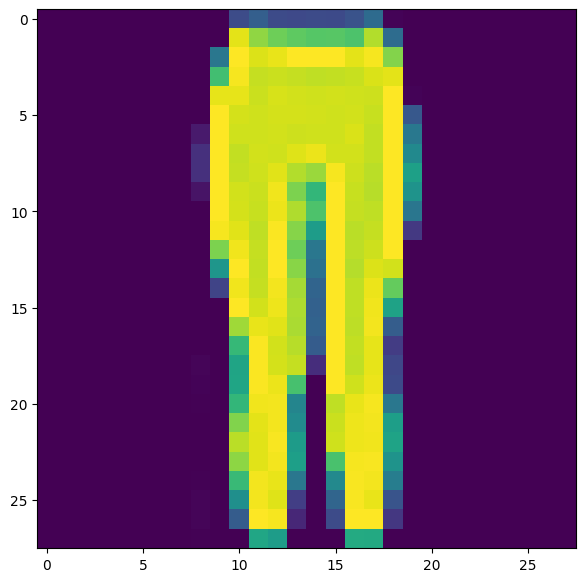

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(data_iterator.next()['image']) # visualizing our input data

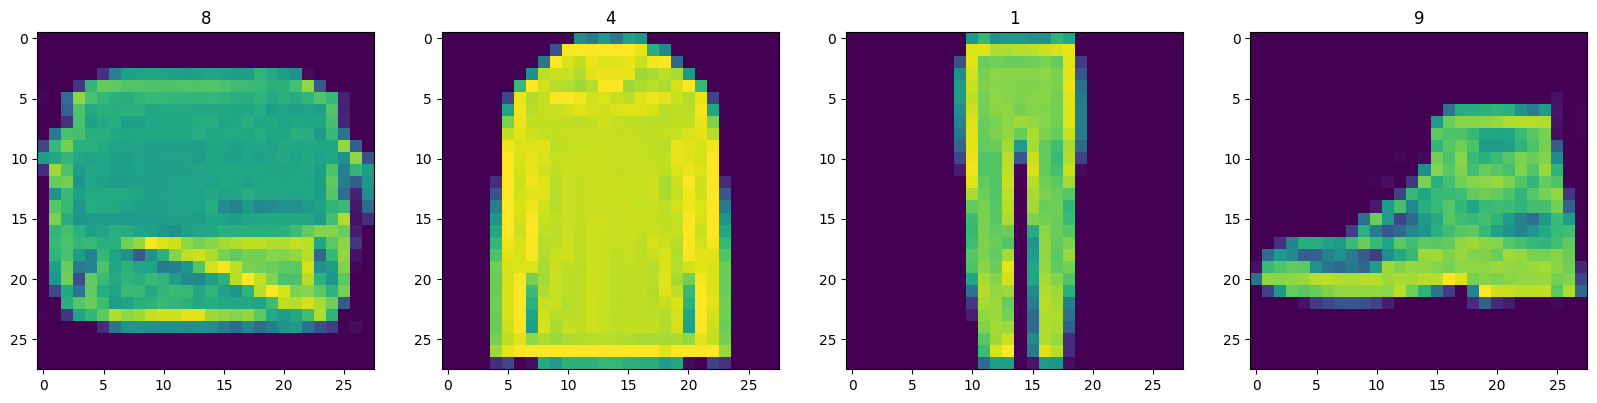

In [ ]:
# visualize
import random
random.seed(42)
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx in range(4):
  batch = data_iterator.next()

  ax[idx].imshow(batch['image'])
  ax[idx].title.set_text(batch['label'])


In [ ]:
def scale_images(ds):
  image = ds['image']
  return image/255

In [ ]:
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Building Neural Network Models


## Building a Generator
- `Dense()` - Used as a connecting block
- `LeakyReLU()` - Activation function
- `Reshape()` - Reshape the tensor from 1D to what ever shape we need
- `UpSampling2D()` - Increases the shape or up samples the shape


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [ ]:
# input size in first block
# upsample 2 times
# go through 2 cnn blocks
# output the final shape - 28,28,1- batch size

def build_generator():
  model = Sequential()

  # configuring input block
  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # upsampling block 1

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5,padding='same'))
  model.add(LeakyReLU(0.2))

  # upsampling block 2

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5,padding='same'))
  model.add(LeakyReLU(0.2))

  # convolution block 1

  model.add(Conv2D(128, 4, padding = 'same'))
  model.add(LeakyReLU(0.2))

  # convolution block 2

  model.add(Conv2D(128,4,padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Reduces to one channel
  model.add(Conv2D(1,4,padding='same', activation = 'sigmoid'))


  return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
# Creating random noise image of the same input shape/ image size
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 30ms/step


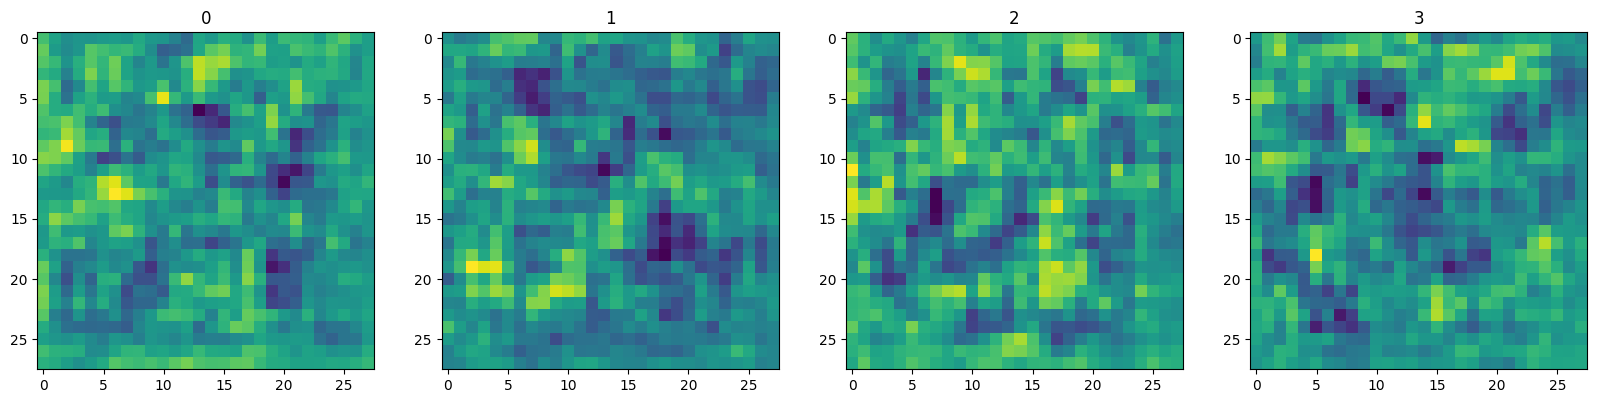

In [ ]:
# Visualize random images generated by noise
img = generator.predict(np.random.randn(4,128,1))

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(img)
  ax[idx].title.set_text(idx)

## Building Discriminator
- `Dropout()` - TO regularise

In [ ]:
# 4 convuluton blocks
# each reduce the size of image and increase the batch size in it
# Finally flatten the network to output 28 by 28 images

def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(tf.expand_dims(img, axis = 0))

1/1 [==============================] - 0s 414ms/step


array([[0.50071996]], dtype=float32)

# Constructing Training Loop

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

loss = BinaryCrossentropy()
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)

In [ ]:
from tensorflow.keras.models import Model

class FashionModelGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.loss = loss

  def train_step(self, batch):

    # Get Data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training = False)

    # Train discriminator

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training = True)
      yhat_fake = self.discriminator(fake_images, training = True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # Create labels
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis =0)

      # Add noise

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis = 0)

      total_d_loss = self.loss(y_realfake, yhat_realfake)

    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
       # Generate some new images
       gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

       # Create the predicted labels
       predicted_labels = self.discriminator(gen_images, training=False)

       # Calculate loss - trick to training to fake out the discriminator
       total_g_loss = self.loss(tf.zeros_like(predicted_labels), predicted_labels)

   # Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
model0 = FashionModelGAN(generator, discriminator)

In [ ]:
model0.compile(g_opt, d_opt, loss)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('GANImages', f'generated_img_{epoch}_{i}.png'))

In [ ]:
hist = model0.fit(ds,epochs=50, callbacks = [ModelMonitor()])

Epoch 1/50
  6/469 [..............................] - ETA: 1:13 - d_loss: 0.3151 - g_loss: 5.8128

469/469 [==============================] - 75s 160ms/step - d_loss: 0.5693 - g_loss: 2.3742
Epoch 2/50
469/469 [==============================] - 76s 162ms/step - d_loss: 0.3415 - g_loss: 1.9830
Epoch 3/50
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2766 - g_loss: 2.6345
Epoch 4/50
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2739 - g_loss: 2.7131
Epoch 5/50
469/469 [==============================] - 76s 163ms/step - d_loss: 0.2731 - g_loss: 2.7224
Epoch 6/50
469/469 [==============================] - 76s 163ms/step - d_loss: 0.2721 - g_loss: 2.6896
Epoch 7/50
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2713 - g_loss: 2.6581
Epoch 8/50
469/469 [==============================] - 76s 163ms/step - d_loss: 0.2704 - g_loss: 2.6330
Epoch 9/50
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2698 - g_loss: 2.6206
Epoch 10/50
469/469 [==============================] - 76s 162ms/step - d_loss: 0.26

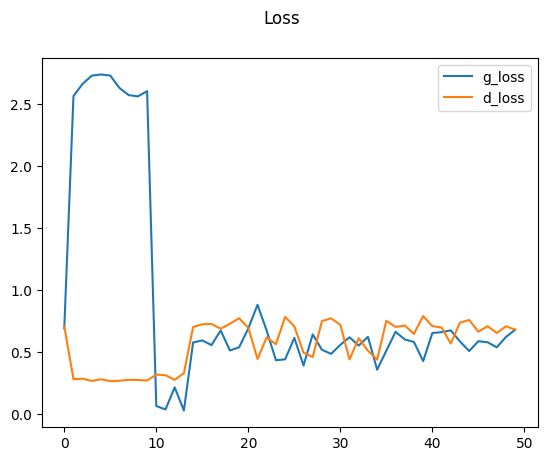

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['g_loss'], label = 'g_loss')
plt.plot(hist.history['d_loss'], label = 'd_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 489ms/step


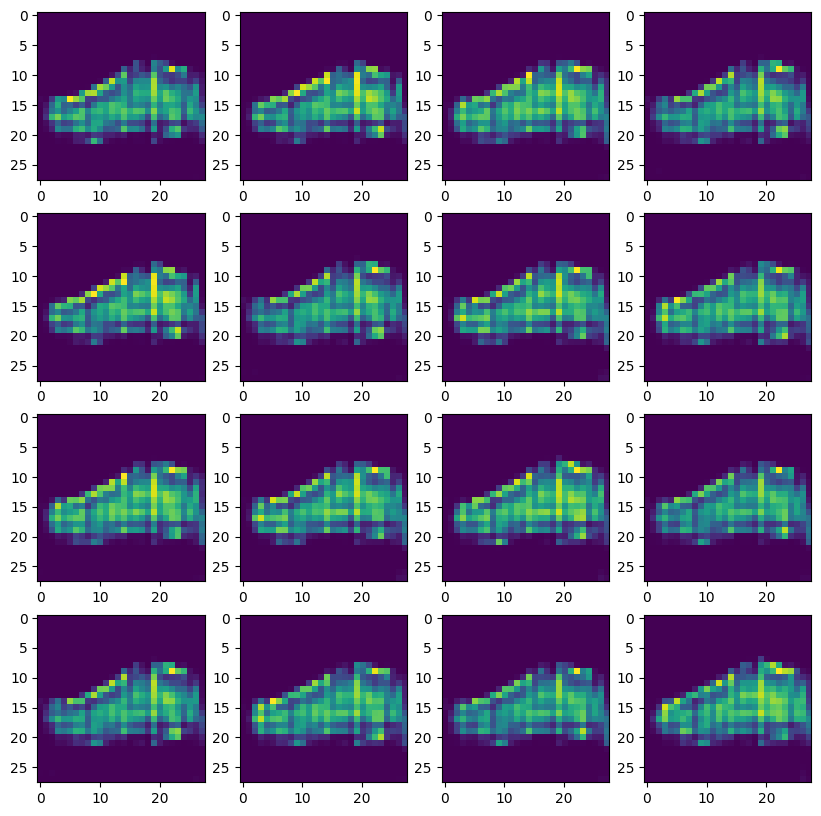

In [ ]:
imgs = generator.predict(tf.random.normal((16,128,1)))
fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize = (10,10))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])